# GEDI Level 2B Vertical Plant Profiles

The GEDI Level 2B product provides vertical cover, plant area index (PAI) and plant area volume density (PAVD) profiles at a vertical resolution of 5 m. This notebook shows how to retrieve the directional gap probability (Pgap) profile from the Level 2B product using GEDIPy, compute these vertical profile metrics at the vertical resolution of the original Level 1B waveform, and then visualize them.

In [33]:
import numpy
import pandas

import matplotlib.pyplot as plt
import ipywidgets

from gedipy import h5io
from dask import delayed, compute, visualize
import numpy as np

## A function to recompute vertical profiles
We need datasets from the Level 2B file to compute the zenith angle of laser shot and also ancillary metrics including the RossG coefficent (canopy element projection function) and Omega coefficient (clumping factor)

In [34]:
def get_vertical_profiles(pgap_theta_z, height, local_beam_elevation, rossg, omega):
    cos_zenith = numpy.abs( numpy.sin(local_beam_elevation) )
    cover_z = cos_zenith * (1.0 - pgap_theta_z)
    pai_z = -(1.0 / (rossg * omega)) * numpy.log(pgap_theta_z) * cos_zenith
    pavd_z = -numpy.gradient(pai_z, height)       
    return cover_z, pai_z, pavd_z

## Open the H5 file
We select one of the power beams for this example

In [35]:
file_path_2B = "/home/stef/Testbed/00_data/GEDI/GEDI02_B_2019113083317_O02042_T04038_02_001_01.h5"
l2b_f = delayed(h5io.GEDIH5File)(file_path_2B)
l2b_f = compute(l2b_f)[0]
l2b_f

In [36]:
l2b_f.open()
beam = 'BEAM1011'
l2b_f.beams

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

## Read all the profiles for one beam
This remaps the 1D pgap_theta_z array to a 2D M x N array, where M is the number Pgap profiles bins and N is the number of GEDI shots

In [37]:
from dask import delayed, compute, visualize

In [38]:
    def _expand(pgap):
            return np.expand_dims(pgap, axis=0)
    
    def read_pgap_theta_z_dask(l2b_f, beam, start=0, finish=None, minlength=None,
                          height=False, start_offset=0):
        """
        Remap the 1D pgap_theta_z array to a 2D M x N array, where M is
        the number Pgap profiles bins and N is the number of GEDI shots
        
        Parameters
        ----------
        beam: str
            Name of beam assessed, i.e. 'BEAM0001'
        start: int
            start of np.ndarray like slicing, Default=0
        finish: int/ None
            end of np.ndarray like slicing, Default=None
        minlength:
            TBD, Default=None
        height: bool
            TBD
        start_offset: str
            TBD
        
        Returns
        -------
        out_pgap_profile: numpy.ndarray
            TBD
        out_height:
            TBD
        """
        if not finish:
            finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])

        start_indices = da.from_array(l2b_f.fid[beam+'/rx_sample_start_index'][start:finish]-1)
        counts = da.from_array(l2b_f.fid[beam+'/rx_sample_count'][start:finish])
        pgap_profile = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][start_indices[0].compute():(start_indices[-1].compute()+counts[-1].compute())])

        max_count = counts.max() + start_offset
        if minlength:
            max_count = max(minlength, max_count)
        out_shape = (max_count.compute(), len(counts))

        out_pgap_profile = da.ones(out_shape, dtype=pgap_profile.dtype)
        pgap = da.from_array(l2b_f.fid[beam+'/pgap_theta'][start:finish])
        x = da.map_blocks(_expand, pgap).compute()
        out_pgap_profile *= x
        
        start_indices -= start_indices.min()       
        l2b_f.waveform_1d_to_2d(start_indices, counts, pgap_profile,
                               out_pgap_profile, start_offset=start_offset)

        if height:
            height_bin0 = l2b_f[beam+'/geolocation/height_bin0'][start:finish]
            height_lastbin = l2b_f[beam+'/geolocation/height_lastbin'][start:finish]
            v = (height_bin0 - height_lastbin) / (counts - 1)

            bin_dist = numpy.expand_dims(numpy.arange(max_count), axis=1)
            out_height = (numpy.expand_dims(height_bin0, axis=0) - 
                numpy.repeat(bin_dist,v.shape[0],axis=1) * v + 
                start_offset * v)

            return out_pgap_profile, out_height
        else:
            return out_pgap_profile

In [39]:
finish=None
start = 0
minlength=None
height=False
start_offset=0
if not finish:
    finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])
    print(finish)

343171


In [40]:
import dask.array as da

In [41]:
start_indices = da.from_array(l2b_f.fid[beam+'/rx_sample_start_index'][start:finish]-1)
counts = da.from_array(l2b_f.fid[beam+'/rx_sample_count'][start:finish])
pgap_profile = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][start_indices[0].compute():(start_indices[-1].compute()+counts[-1].compute())])

In [42]:
max_count = counts.max() + start_offset
if minlength:
    max_count = max(minlength, max_count)
out_shape = (max_count.compute(), len(counts))

In [43]:
out_shape

(1002, 343171)

In [44]:
out_pgap_profile = da.ones(out_shape, dtype=pgap_profile.dtype)
out_pgap_profile.shape

(1002, 343171)

In [45]:
pgap = da.from_array(l2b_f.fid[beam+'/pgap_theta'][start:finish])

In [46]:
pgap.shape

(343171,)

In [47]:
def expand(pgap):
    return np.expand_dims(pgap, axis=0)

x = da.map_blocks(expand, pgap).compute()
out_pgap_profile *= x
start_indices -= start_indices.min()

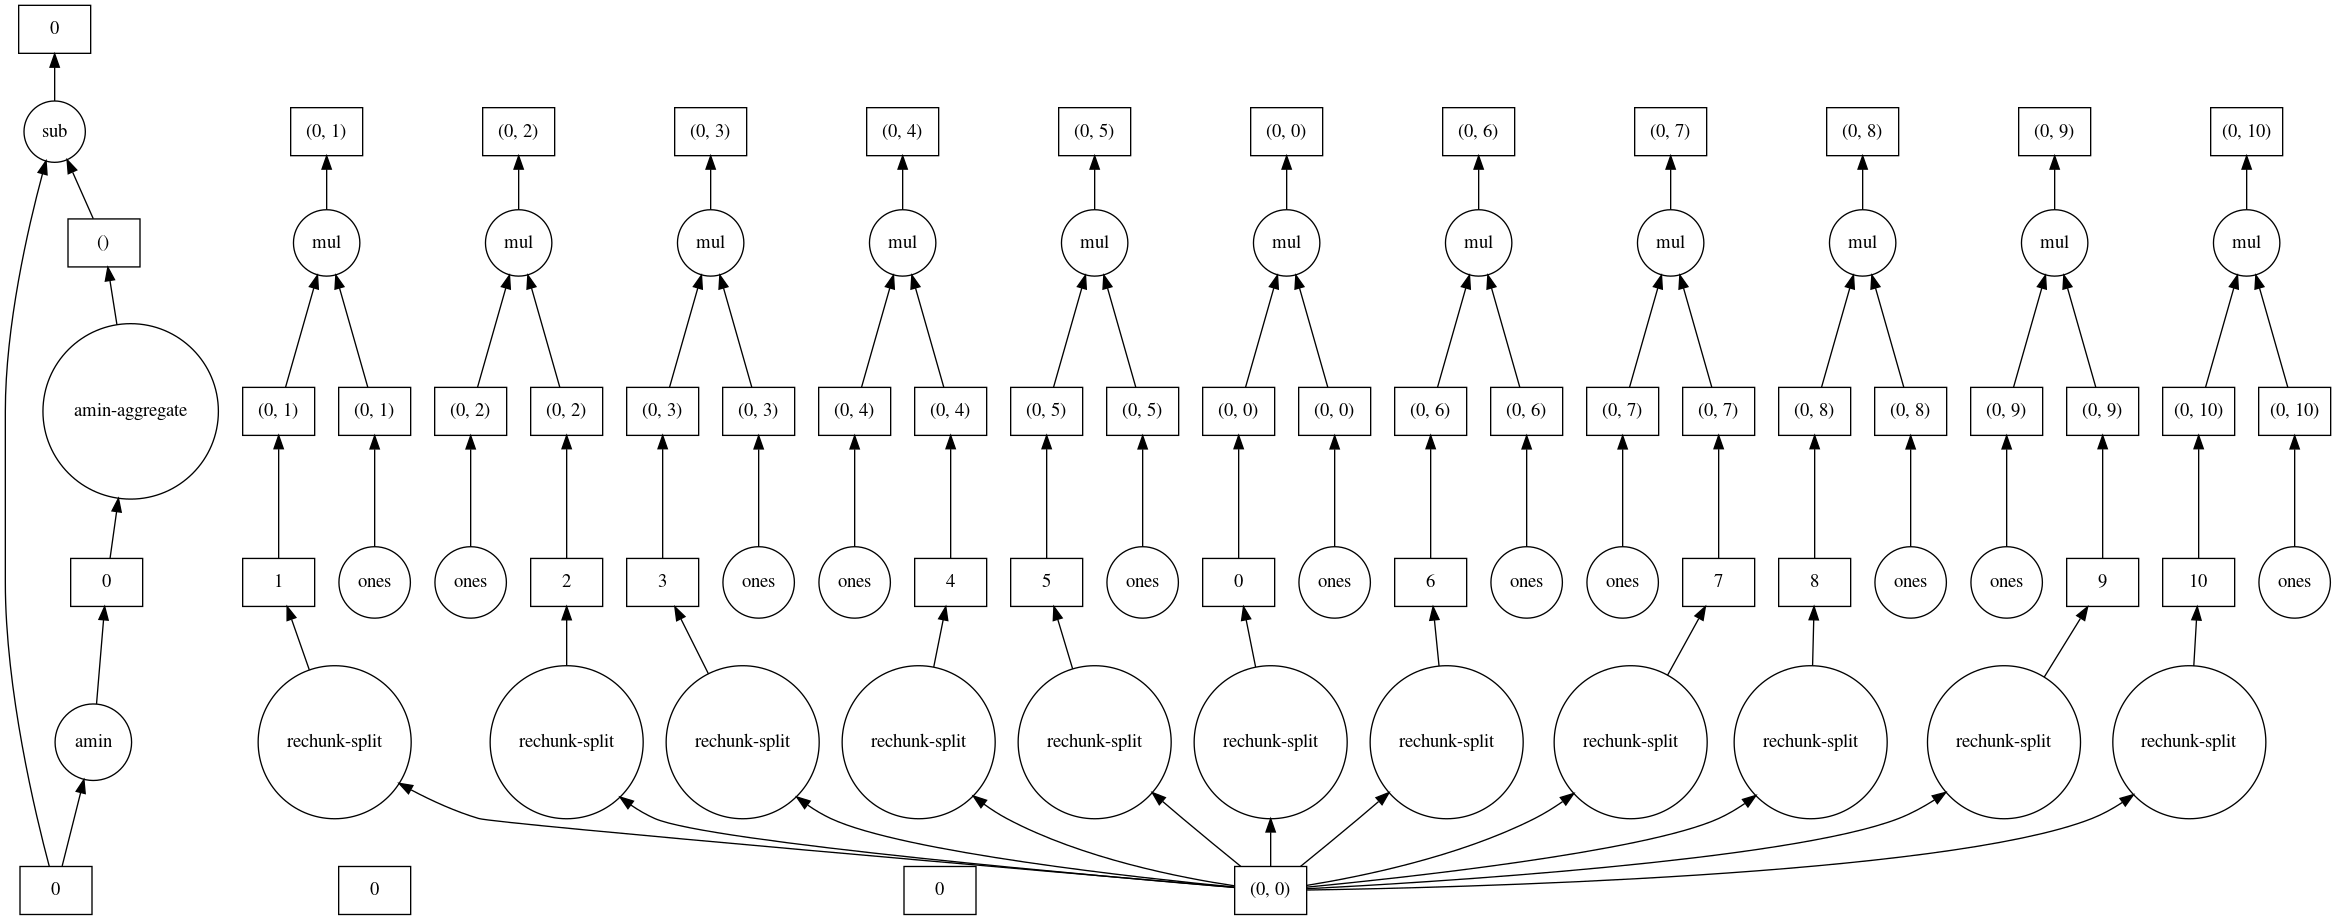

In [48]:
visualize(start_indices, counts, pgap_profile, out_pgap_profile)

In [49]:
l2b_f.waveform_1d_to_2d(start_indices, counts, pgap_profile,
                               out_pgap_profile, start_offset=start_offset)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
[1] During: typing of argument at /home/stef/miniconda3/envs/gedi/lib/python3.8/site-packages/gedipy/h5io.py (224)

File "../../../miniconda3/envs/gedi/lib/python3.8/site-packages/gedipy/h5io.py", line 224:
    def waveform_1d_to_2d(start_indices, counts, data, out_data, start_offset=0):
        for i in prange(start_indices.shape[0]):
        ^

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'dask.array.core.Array'>
- argument 1: cannot determine Numba type of <class 'dask.array.core.Array'>
- argument 2: cannot determine Numba type of <class 'dask.array.core.Array'>
- argument 3: cannot determine Numba type of <class 'dask.array.core.Array'>

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'dask.array.core.Array'>
- argument 1: cannot determine Numba type of <class 'dask.array.core.Array'>
- argument 2: cannot determine Numba type of <class 'dask.array.core.Array'>
- argument 3: cannot determine Numba type of <class 'dask.array.core.Array'>


In [41]:
        if height:
            height_bin0 = da.from_array(fid.l2b_f[beam+'/geolocation/height_bin0'][start:finish])
            height_lastbin = da.from_array(fid.l2b_f[beam+'/geolocation/height_lastbin'][start:finish])
            v = (height_bin0 - height_lastbin) / (counts - 1)

            bin_dist = numpy.expand_dims(numpy.arange(max_count), axis=1)
            out_height = (numpy.expand_dims(height_bin0, axis=0) - 
                numpy.repeat(bin_dist,v.shape[0],axis=1) * v + 
                start_offset * v)

            return out_pgap_profile, out_height
        else:
            return out_pgap_profile

numpy.ndarray

In [27]:
# start_offset is used to buffer the start of the profile with pgap_theta_z = 1
start_offset = 5

result = l2b_f.read_pgap_theta_z(beam, height=True, start_offset=start_offset, dask=True)
pgap_theta_z, height = result[0], result[1]

visualize(pgap_theta_z, height)


TypeError: slice indices must be integers or None or have an __index__ method

## Read waveform and ancillary metrics

In [8]:
# Only read what we need - note that rh100 is in units of cm
dataset_l = ['shot_number', 'rh100', 'omega', 'rossg', 'l2b_quality_flag', 
                'pgap_theta_error', 'geolocation/local_beam_elevation']
l2b_data = l2b_f.read_shots(beam, dataset_list=dataset_l)

# Get the index of all quality shots
idx, = numpy.nonzero(l2b_data['l2b_quality_flag'])

# Use pandas to make it print nice
df = pandas.DataFrame(l2b_data)
df

,shot_number,rh100,omega,rossg,l2b_quality_flag,pgap_theta_error,local_beam_elevation
0,20421100100000001,0,1.0,0.5,0,-9999.000000,1.558602
1,20421100300000002,288,1.0,0.5,0,0.000114,1.558590
2,20421100500000003,288,1.0,0.5,0,0.000178,1.558589
3,20421100700000004,299,1.0,0.5,0,0.000056,1.558589
4,20421100900000005,292,1.0,0.5,0,0.000096,1.558589
...,...,...,...,...,...,...,...
343166,20421123300343167,322,1.0,0.5,0,0.000025,1.553505
343167,20421123500343168,306,1.0,0.5,0,0.000011,1.553504
343168,20421123700343169,318,1.0,0.5,0,0.000028,1.553504
343169,20421123900343170,336,1.0,0.5,0,0.000141,1.553504


In [15]:
import numpy as np

In [25]:
x = np.array([np.random.rand(10)])
x.max()

0.8822995549833164

In [42]:
import dask.array as da

In [43]:
x = da.from_array(l2b_data)
x

dask.array<array, shape=(343171,), dtype=[('shot_number', '<u8'), ('rh100', '<i2'), ('omega', '<f4'), ('rossg', '<f4'), ('l2b_quality_flag', 'u1'), ('pgap_theta_error', '<f4'), ('local_beam_elevation', '<f4')], chunksize=(343171,), chunktype=numpy.ndarray>

In [44]:
x.shape

(343171,)

In [ ]:
import dask.dataframe as dd

In [ ]:
ddf = dd.from_array(l2b_data)
ddf.tail()

## Plot example vertical plant profiles

In [ ]:
%matplotlib inline

def update(index=0):
    i = idx[index]
    
    err = l2b_data['pgap_theta_error'][i]
    rh100 = l2b_data['rh100'][i] / 100
        
    cover_z, pai_z, pavd_z = get_vertical_profiles(pgap_theta_z[:,i], height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    cover_z0, pai_z0, pavd_z0 = get_vertical_profiles(pgap_theta_z[:,i]-err, height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    cover_z1, pai_z1, pavd_z1 = get_vertical_profiles(pgap_theta_z[:,i]+err, height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    
    first_canopy = numpy.argwhere(pgap_theta_z[:,i] < 1)[0][0]
    max_height = height[first_canopy,i]
    peak_canopy = numpy.argmax(pavd_z)
    peak_height = height[peak_canopy,i]
    
    fig,axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    
    axs[0].fill_betweenx(height[:,i], pgap_theta_z[:,i]-err, pgap_theta_z[:,i]+err, 
                         facecolor='lightgrey')
    axs[0].plot(pgap_theta_z[:,i], height[:,i], color='black')
    axs[0].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[0].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[0].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[0].legend(loc='upper right')
    
    axs[1].fill_betweenx(height[:,i], cover_z0, cover_z1, facecolor='lightgrey')
    axs[1].plot(cover_z, height[:,i], color='black')    
    axs[1].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[1].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[1].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[1].legend(loc='upper right')
    
    axs[2].fill_betweenx(height[:,i], pai_z0, pai_z1, facecolor='lightgrey')
    axs[2].plot(pai_z, height[:,i], color='black')
    axs[2].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[2].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[2].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[2].legend(loc='upper right')
    
    axs[3].fill_betweenx(height[:,i], pavd_z0, pavd_z1, facecolor='lightgrey')
    axs[3].plot(pavd_z, height[:,i], color='black')
    axs[3].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[3].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[3].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[3].legend(loc='upper right')

    axs[0].set(xlim=(0, 1), ylim=(-2.5, height[first_canopy,i]+7.5), 
               title=r'$P_{gap} (\theta, z=0):\/$' + \
                     '{:.2f}'.format(pgap_theta_z[-1,i]),
               xlabel=r'$P_{gap} (\theta,z)$', ylabel='Height (m)')
    axs[1].set(xlim=(0, 1), xlabel='Canopy Cover Fraction (z)',
               title='CCF (z=0): {:.2f}'.format(cover_z[-1]))
    axs[2].set(xlim=(0, max(1,pai_z0[-1])), xlabel=r'$PAI (z)\/[m^{2} m^{-2}]$',
               title='PAI (z=0): {:.2f}'.format(pai_z[-1]))
    axs[3].set(xlim=(0, max(0.1,max(pavd_z0))), xlabel=r'$PAVD (z)\/[m^{2} m^{-3}]$',
               title=r'$H\/(z=max,top):\/$' + \
                     '{:.2f},{:.2f}'.format(peak_height,max_height))
    
    fig.suptitle('Vertical Plant Profiles (shot number: {:018d})'.format(l2b_data['shot_number'][i]))   
    fig.canvas.draw()
    
update(index=10542)

## Generate an interactive plot

In [ ]:
nrecords = numpy.count_nonzero(l2b_data['l2b_quality_flag'])
ipywidgets.interact(update, index=ipywidgets.IntSlider(min=0, max=nrecords-1, step=1, 
                                                       value=10542, continuous_update=False))